This notebook shows the steps to build user-user collaborative recommendation system using the Movielens dataset. This is the third in a three-part series on recommendation systems as indicated below.

* Content-based : that uses only item similarity
* Hybrid RS: that uses item similarity along with user ratings  
* Collaborative RS: only uses user ratings


MovieLens data sets were collected by the GroupLens Research Project at the University of Minnesota.

This data set consists of:
	* 100,000 ratings (1-5) from 943 users on 1682 movies. 
	* Each user has rated at least 20 movies. 
    
URL: https://grouplens.org/datasets/movielens/100k/
Date of download: 23 Feb 2019

Collaborative filtering leverages user similarity and behavior to give recommendations. In this type of model, for a specific user, we find similar users based on past behavior and recommend items that the user in question hasn’t purchased yet and which the similar users tended to like.

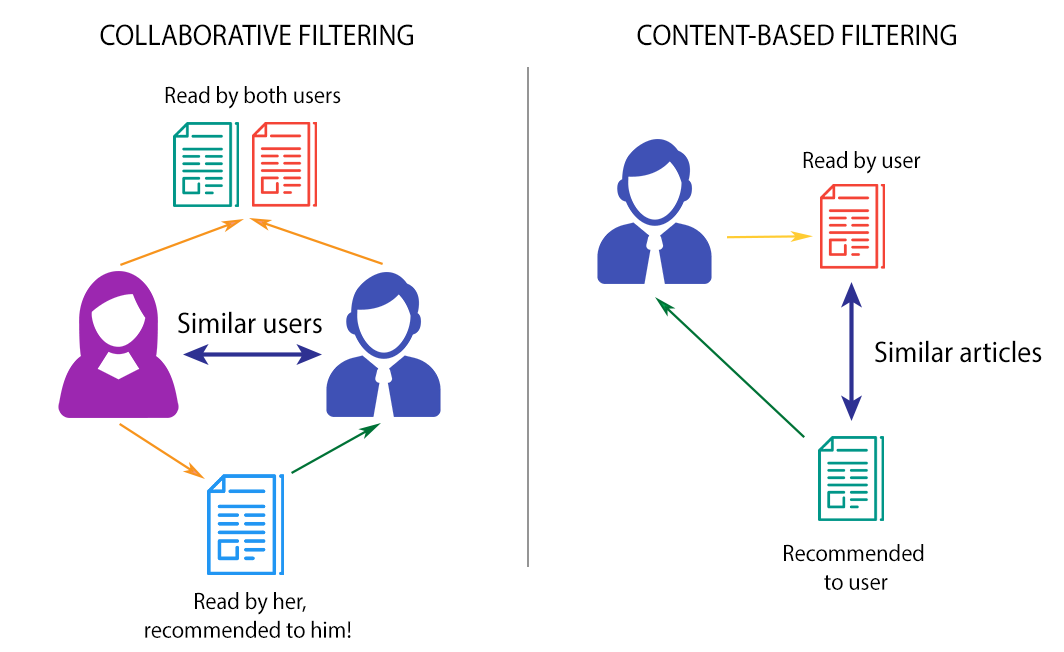

Source: http://datameetsmedia.com/an-overview-of-recommendation-systems/

The prediction of an item for a user u is calculated by computing the weighted sum of the user ratings given by other users to an item i. 
In general,this can be expressed as,

**Prediction Pui= sum of the product of ratings and similarities between users (or items in the case of item-item sim) divided by the sum of similarities of the users (or items)**
                   with the summation being over all other users


To estimate similarity, we will use cosine distance between the two paiwise elements in this exercise.

In [2]:
import pandas as pd
import numpy as np
import math
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import pairwise_distances 


### Lets import all the datasets

#### _ Dataset info _

This dataset contains information about 1682 movies (items), 943 users and 100,000 ratings. 
The movies are categorized into 18 genres as shown in the u_genre dataframe.



In [3]:
#Dataset info
u_info = pd.read_csv('ml-100k/u.info') #, header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
u_info


,943 users
0,1682 items
1,100000 ratings


We can get a better sense of the distribution of the movies in various genres by plotting a histogram for all genres. 

#### _ Users dataframe _ 
The following dataframe, users contains general information about the users, like age, gender, occupation and zip code.

In [105]:
##Information about ratings (u.user)
users = pd.read_csv('ml-100k/u.user', sep='|', names=['user id','age', 'gender', 'occupation','zip code'],encoding='latin-1')
print(users.shape)
users.set_index('user id',inplace=True)
users.head()


(943, 5)


,age,gender,occupation,zip code
user id,,,,
1,24,M,technician,85711
2,53,F,other,94043
3,23,M,writer,32067
4,24,M,technician,43537
5,33,F,other,15213


#### _ Items dataframe _
The items dataframe contains detailed binary repreentation of the genres of each item in the dataset . We dont't explicitly need this for collaborative filtering but we are importing it so that we can pull movie names based on the ids.

In [12]:
#Information about movies (u.item)
## the last 19 fields are genres of type boolean; movies can be of multiple genres
i_cols = ['movie id', 'movie title','release date','video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure',
'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
items = pd.read_csv('ml-100k/u.item', sep='|', names=i_cols, encoding='latin-1')
#items=items.drop(labels=['release date','video release date','IMDb URL', 'unknown', 'Action', 'Adventure',
#'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'],axis=1)
print(items.shape)
items.set_index('movie id', inplace=True)
items.head()

(1682, 24)


,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movie id,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


#### _ Ratings dataframe _

The ratings data is the most important dataframe in the dataset, and contains the rating on a scale of 1-5 given by each user for all the movies they have watched.

In [6]:
##Information about ratings (u.data)
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id','movie id', 'rating', 'timestamp'],encoding='latin-1')
ratings.drop(labels='timestamp',axis=1,inplace=True)
print(ratings.shape)
ratings.head()

(100000, 3)


,user_id,movie id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


### Building the collaborative filter

In [7]:
#calculate number of unique movies (items) and users
n_users = ratings['user_id'].unique().shape[0]
n_items = ratings['movie id'].unique().shape[0]
print("Number of users:",n_users)
print("Number of users:",n_items)

Number of users: 943
Number of users: 1682


#### Create a data matrix
To calculate the similarity between users and items, we need a user-item matrix (n_users x n_items). 
Each row represents a user and each column represents a movie.

In [9]:
data_matrix=np.zeros((n_users,n_items))
for row in ratings.itertuples():                         
    data_matrix[row[1]-1,row[2]-1]=row[3]
data_matrix.shape

(943, 1682)

#### Item-item Collaborative filter

The item similarity matrix defines the similarities between pairs of movies. It can be calculated for all movie pairs using the pairwise distance function. The pairwise distance is equal to (1 - cosine similarity) for a given pair of vectors. So, a _high cosine similarity would imply that paritwise distance would be small._

##### This step is the same as building a content based filter

In [10]:
#we can now estimate user-item similarities using pairwise distance function 
item_similarity = pairwise_distances(data_matrix.T, metric='cosine')
item_similarity.shape

(1682, 1682)

For example, let's find movies similar to "Star Wars" below. To find movies that are similar to a Star Wars, we find the row containing Star Wars in the item similarity matrix and sort it in ascending order. Smaller values of pairwise distances are movies that most similar.

It is important to note that the items dataframe is indexed by movie_id, which starts from 1, while the vectors for similarity is indexed starting from 0. 

In [32]:
#Movies similar to batman
starwars_id=items[items['movie title'].str.contains('Star Wars')].index.values[0]
max_simi_movie=item_similarity[batman_id-1].argsort()[:10]

#print("Pairwise distances",np.sort(item_similarity[batman_id-1])[:5])

for i in max_simi_movie[1:]:
    print(items['movie title'].loc[i+1])


Return of the Jedi (1983)
Raiders of the Lost Ark (1981)
Empire Strikes Back, The (1980)
Toy Story (1995)
Godfather, The (1972)
Independence Day (ID4) (1996)
Indiana Jones and the Last Crusade (1989)
Fargo (1996)
Silence of the Lambs, The (1991)


In [33]:
#Movies similar to Shawshank Redemption
shawshank_id=items[items['movie title'].str.contains('Shawshank')].index.values[0]
max_simi_movie=item_similarity[shawshank_id-1].argsort()[:10]

#print("Pairwise distances",np.sort(item_similarity[shawshank_id-1])[:5])

for i in max_simi_movie[1:]:
    print(items['movie title'].loc[i+1])


Forrest Gump (1994)
Raiders of the Lost Ark (1981)
Silence of the Lambs, The (1991)
Pulp Fiction (1994)
Schindler's List (1993)
Braveheart (1995)
Usual Suspects, The (1995)
Dead Poets Society (1989)
Back to the Future (1985)


##### Now we can incorporate ratings into the recommendations by taking the weighted sum for a users ratings  
Now lets write a function to calculate the prediction for recommendations based on the equation: ** dot(ratings,similarity)/sum(similarity) ** over all the movies

In [343]:
def predict(data, similarity):
    pred=data.dot(similarity)/np.array([np.abs(similarity).sum(axis=1)])
    return pred

the prediction matrix will be 943 x 1682, where each row represents the ranking for recommendations for the user. Once again, we will sort the 1st row in ascending order and the movies corresponding to smallest 5 values will be the most liked movies for this user.


Lets consider user_id = 1

In [358]:
item_sim_result=predict(data_matrix,item_similarity)
user_1_recs=item_sim_result[0].argsort()[:5]

for i in user_1_recs:
    print(items['movie title'].loc[i+1])


Raiders of the Lost Ark (1981)
Empire Strikes Back, The (1980)
Back to the Future (1985)
Monty Python and the Holy Grail (1974)
Pulp Fiction (1994)


These movies mainly fall in the Action, Sci Fi, Comedy and Drama categories whihc were the top 4 genres we identified for user 1 in the content based filtering exercise as well. 

### Next, lets build a user-user collaborative filter

First, we need a user-user similarity matrix. This will be 943 x 943 in size to represent the similarity between each pair of users based on their movie watching data.

In [109]:
user_similarity = pairwise_distances(data_matrix, metric='cosine')
user_similarity.shape

(943, 943)

In [422]:
#lets find users most similar to user 1 and call them his buddies
user_1_buddies=user_similarity[0].argsort()[:5]
user_1_buddies #index not user-id

array([  0, 915, 863, 267,  91], dtype=int64)

We need a predict function as before to find the user prediction matrix. However, the issue is shape compatibility between user similarity matrix (943x943) and the data matrix (943 x 1062)

In [417]:
def predict_useruser(data, similarity):
    mean_user_rating = data.mean(axis=1) #shape 943
    mean_user_rating=mean_user_rating[:,np.newaxis] #shape 943x1
    
    #we use np.newaxis so that mean_user_rating has same format as ratings
    ratings_diff = (data - mean_user_rating) #943x1682

    pred = mean_user_rating + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
   
    return pred

In [453]:
user_sim_result=predict_useruser(data_matrix,user_similarity)
user_sim_result.shape
user_1_recs=user_sim_result[0].argsort()[:5]

for i in user_1_recs:
    print(items['movie title'].loc[i+1])


(943, 1682)
Nobody Loves Me (Keiner liebt mich) (1994)
Police Story 4: Project S (Chao ji ji hua) (1993)
Bloody Child, The (1996)
Power 98 (1995)
Butterfly Kiss (1995)


In [444]:
#recommendations for user id 916 (index 915)
user_916_recs=user_sim_result[915].argsort()[:5]

for i in user_916_recs:
    print(items['movie title'].loc[i+1])


Scream of Stone (Schrei aus Stein) (1991)
Butterfly Kiss (1995)
Police Story 4: Project S (Chao ji ji hua) (1993)
Power 98 (1995)
Bloody Child, The (1996)


We have checked that user 1 and user 916, who are very similar as per their user-user similarity score, have similar recommendations.

### Limitations of Collaborative Recommendation system
1) A collaborative recommedation system works great when user or item data is available. It fails to deal with the cold start problem, where initially for a new user or new movie, we dont have any interaction data.

2) They are not as transparent as content based models, where the similarity between movies or items can be easily compared baed on domain knowledge. These systems are more complex.

However, these are very popular models taht are widely being used today and very successful in predicting user preferences.